# PyALE: Usage examples

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

## Prepare Data

In [2]:
# get the raw diamond data (from R's ggplot2)
dat_diamonds = pd.read_csv(
    "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
)
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy()
y = dat_diamonds["price"].copy()

In [3]:
X = X_raw.copy()
# convert the three text columns to ordered categoricals
X["cut"] = X["cut"].astype(
    pd.api.types.CategoricalDtype(
        categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True
    )
)
X["clarity"] = X["clarity"].astype(
    pd.api.types.CategoricalDtype(
        categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
        ordered=True,
    )
)

In [4]:
# use the codes of each categorical as a numeric encoding for the feature
X["cut_code"] = X["cut"].cat.codes
X["clarity_code"] = X["clarity"].cat.codes

In [5]:
# fit a one-hot-encoder before the function
# it is important to use a one-hot-encoder, that is fitted with all possible
# categories in the feature.
one_hot_encoder = OneHotEncoder().fit(X[["color"]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

In [6]:
coded_feature = onehot_encode(X[["color"]])
X = pd.concat([X, coded_feature], axis=1)

In [7]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code,D,E,F,G,H,I,J
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features = ["carat", "cut_code", "clarity_code", "depth", "table", "x", "y", "z"]
features = features + coded_feature.columns.to_list()

In [9]:
X[features].head()

,carat,cut_code,clarity_code,depth,table,x,y,z,D,E,F,G,H,I,J
0,0.23,4,1,61.5,55.0,3.95,3.98,2.43,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,3,2,59.8,61.0,3.89,3.84,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,1,4,56.9,65.0,4.05,4.07,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,3,3,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,1,1,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Fit the model

In [10]:
model = RandomForestRegressor(random_state=1345)
model.fit(X[features], y)

RandomForestRegressor(random_state=1345)

## ALE plots

In [11]:
from PyALE import ale

### continuous feature

PyALE._ALE_generic:INFO: Continuous feature detected.


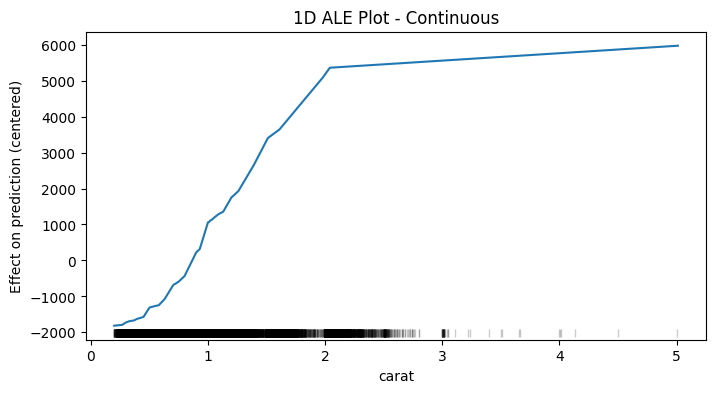

In [12]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X[features], model=model, feature=["carat"], grid_size=50, include_CI=False
)

### continuous feature with confidence interval

PyALE._ALE_generic:INFO: Continuous feature detected.


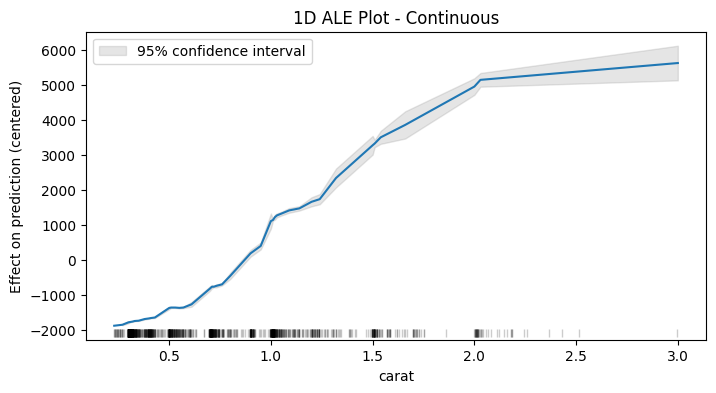

In [13]:
## 1D - continuous - with 95% CI
random.seed(123)
X_sample = X[features].loc[random.sample(X.index.to_list(), 1000), :]
ale_eff = ale(
    X=X_sample, model=model, feature=["carat"], grid_size=50, include_CI=True, C=0.95
)

### Discrete feature

PyALE._ALE_generic:INFO: Discrete feature detected.


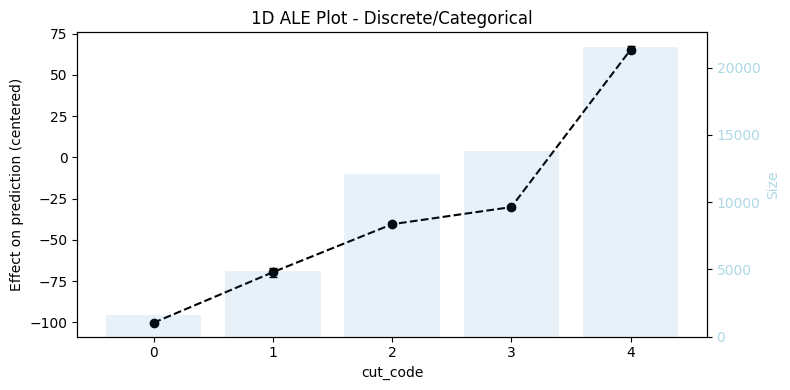

In [14]:
## 1D - discrete
ale_eff = ale(X=X[features], model=model, feature=["cut_code"])

### categorical feature

In [15]:
# prepare dataset to include the raw feature
# since X already has the raw feature it is enough to drop its encoding columns 
X_feat_raw = X.drop(coded_feature.columns.to_list(), axis=1, inplace=False).copy()

PyALE._ALE_generic:INFO: categorical feature detected.


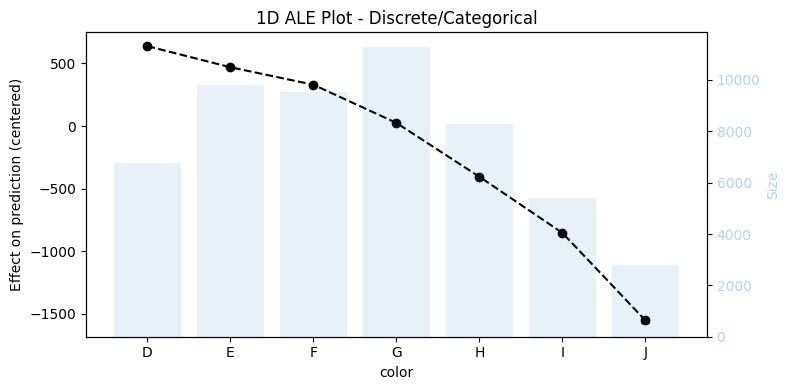

In [16]:
## 1D - categorical
ale_eff = ale(
    X=X_feat_raw,
    model=model,
    feature=["color"],
    encode_fun=onehot_encode,
    predictors=features,
)

### another categorical feature with a custom encoding fucntion

In [17]:
def numeric_encode(col_df):
    feat_name = col_df.columns[0]
    encoding = X[[feat_name, feat_name + '_code']].drop_duplicates()
    encode_dict = {v[feat_name]:v[feat_name + '_code'] for i, v in encoding.iterrows()}
    ret_df = pd.DataFrame({feat_name + '_code': [encode_dict.get(k) for k in col_df.values.ravel()]})
    return ret_df

PyALE._ALE_generic:INFO: categorical feature detected.


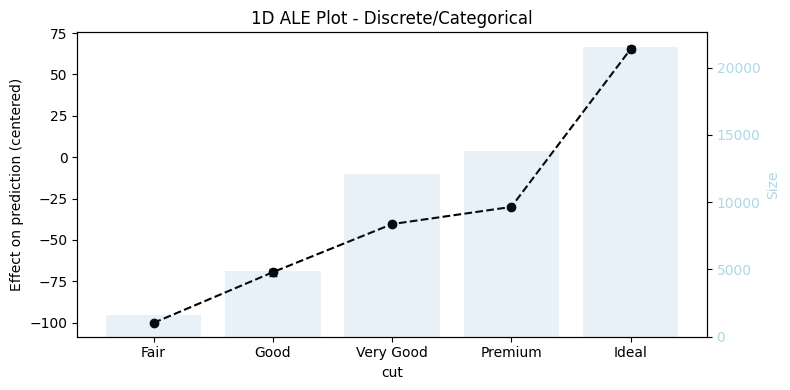

In [18]:
# just like the previous example we need to work with the raw feature and not the encoding
# since X already has the raw feature it is enough to drop its encoding columns 
X_feat_raw = X.drop('cut_code', axis=1, inplace=False).copy()
eff_df = ale(X=X_feat_raw, 
             model=model,
             feature=['cut'],
             encode_fun=numeric_encode, 
             predictors=features,
             include_CI=True, 
             C=0.9)

### 2D numeric features

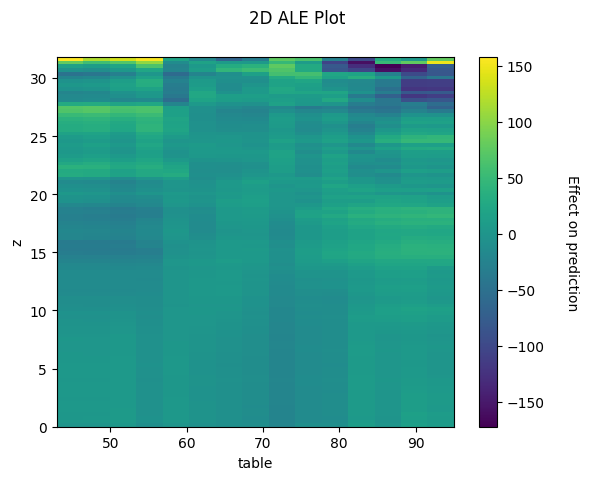

In [19]:
## 2D - continuous
ale_eff = ale(X=X[features], model=model, feature=["z", "table"], grid_size=100)

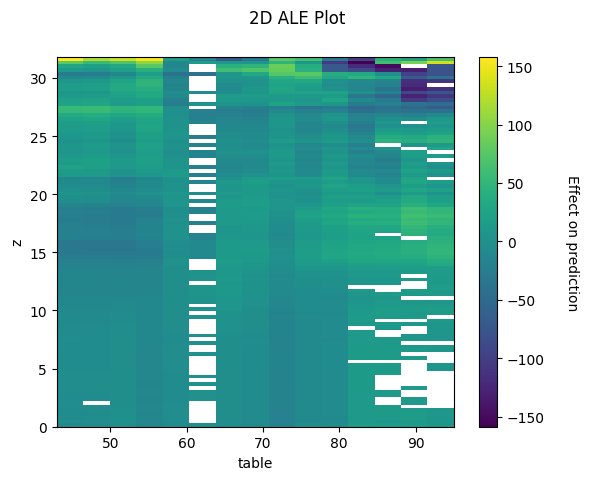

In [25]:
## 2D - continuous - do not impute empty cells
ale_eff = ale(X=X[features], model=model, feature=["z", "table"], grid_size=100, impute_empty_cells=False)

### customizable plotting

Text(0.5, 0, 'width of top of diamond relative to widest point (43-95)')

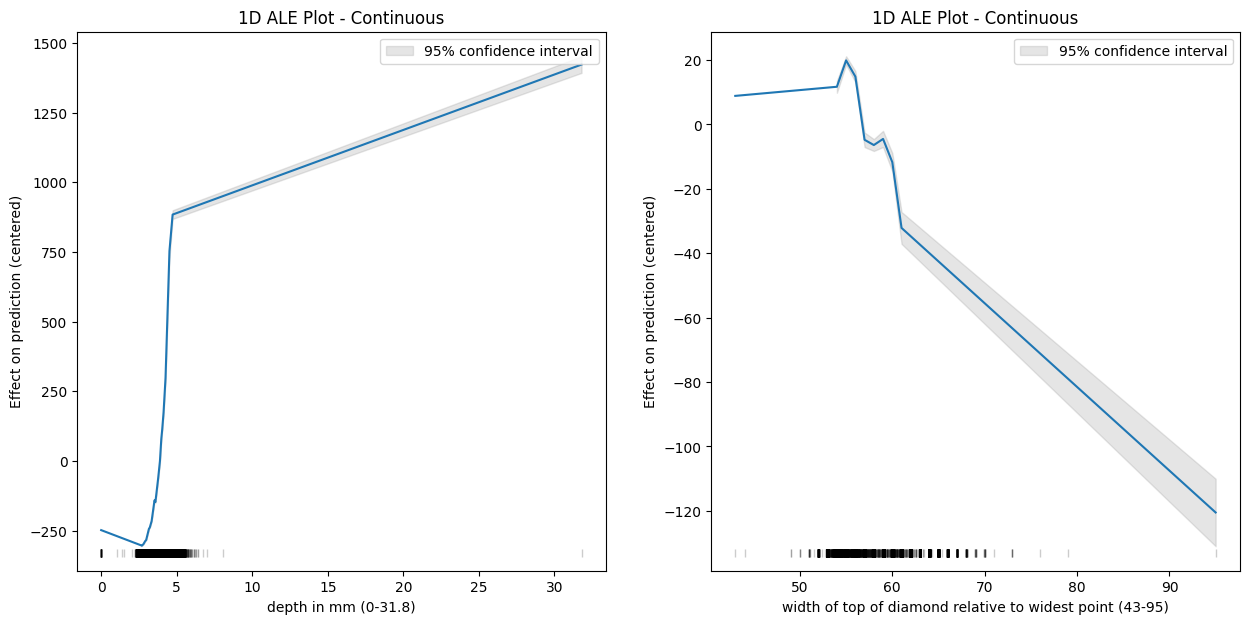

In [20]:
## two 1D plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ale_res_1 = ale(
    X=X[features],
    model=model,
    feature=["z"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=ax1,
)
ale_res_2 = ale(
    X=X[features],
    model=model,
    feature=["table"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=ax2,
)
# change x labels
ax1.set_xlabel("depth in mm (0-31.8)")
ax2.set_xlabel("width of top of diamond relative to widest point (43-95)")

### smaller grid size and fewer data points

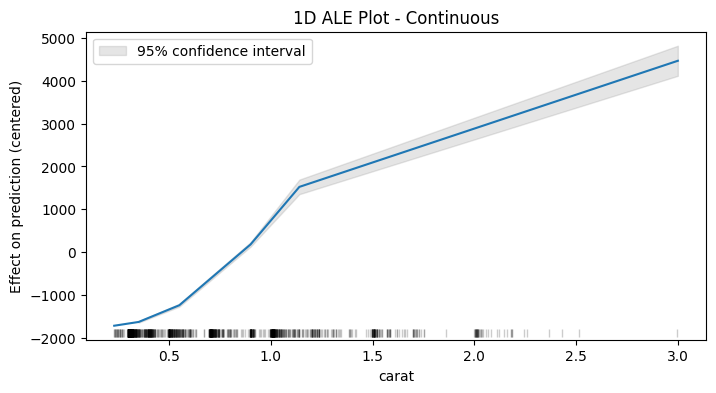

In [21]:
random.seed(123)
X_sample = X[features].loc[random.sample(X.index.to_list(), 1000), :]
ale_contin = ale(
    X=X_sample,
    model=model,
    feature=["carat"],
    feature_type="continuous",
    grid_size=5,
    include_CI=True,
    C=0.95,
)

In [22]:
ale_contin

,eff,size,lowerCI_95%,upperCI_95%
carat,,,,
0.23,-1721.408141,0.0,NaN,NaN
0.35,-1633.405685,203.0,-1650.042600,-1616.768770
0.55,-1242.989786,204.0,-1275.489577,-1210.489995
0.90,176.838662,213.0,125.162929,228.514394
1.14,1521.617690,182.0,1351.287932,1691.947448
3.00,4467.185422,198.0,4115.599415,4818.771429


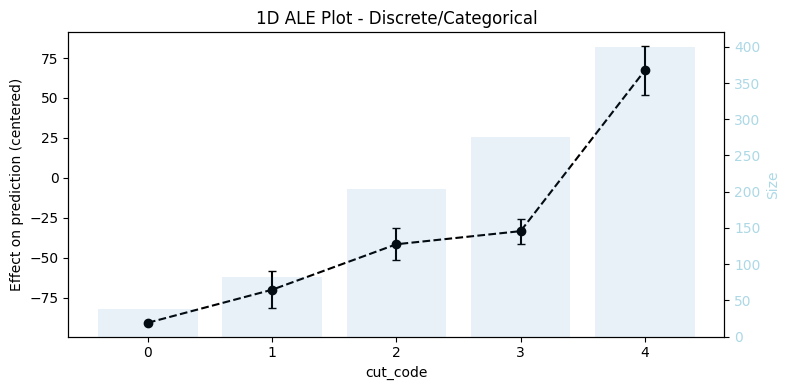

In [23]:
ale_discr = ale(
    X=X_sample,
    model=model,
    feature=["cut_code"],
    feature_type="discrete",
    include_CI=True,
    C=0.95,
)

In [24]:
ale_discr

,eff,size,lowerCI_95%,upperCI_95%
cut_code,,,,
0,-90.799533,38,NaN,NaN
1,-70.106933,82,-81.689547,-58.524319
2,-41.629904,204,-51.675662,-31.584146
3,-33.406766,276,-41.209584,-25.603949
4,67.279797,400,52.097705,82.461888
